# Example Usage of EQTransformer from seisbench using streams
This notebook experiments on how to train seisbench models with [obspy](https://docs.obspy.org/) data streams.

In [2]:
import seisbench.generate as sbg
import seisbench.models as sbm

from seisbench.data import WaveformDataset
from seisbench.models import EQTransformer
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader


Load the 100Samples dataset from the EQTransformer repository but transformed into seisbench-compatible format.

In [3]:
example_data = WaveformDataset("data/STEAD/example/seisbench")


Instantiate a version of seisbench’s EQTransformer

In [4]:
eqt = EQTransformer()
eqt = sbm.EQTransformer.from_pretrained("original")
phasenet = sbm.PhaseNet.from_pretrained('stead')


This part is slightly weird, but the *data* contains information about what is training, validation, and test, already.
In this case, I just randomly designated 81 samples as training data, 9 as dev/validation data, and the remaining 10 as test data; see also the “Convert Example Data to Seisbench Format” notebook.

In [5]:
train, dev, test = example_data.train_dev_test()


Rename the label columns.

In [6]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_s_arrival_sample": "S"
}


Perform (minimal) data augmentation.  I assume (but did not test) that `ChangeDtype` is necessary for the code to run; `ProbabilisticLabeller` provides the probability curves below, but I do not know how they are calculated.

In [7]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(train)

augmentations = [
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)


In [12]:
sample = dev_generator[np.random.randint(len(dev_generator))]
sample = dev_generator[0]


In [16]:
from obspy import Stream
from obspy import Trace

data_stream = Stream()
waveform = ['HHE', 'HHN', 'HHZ']
for i, s in enumerate(sample['X']):
  data_stream.append(Trace(s, {'sampling_rate': 100, 'channel': waveform[i]}))


In [14]:
phasenet.eval() # Close model for evaluation
pn_preds = phasenet.annotate(data_stream)


### Plot

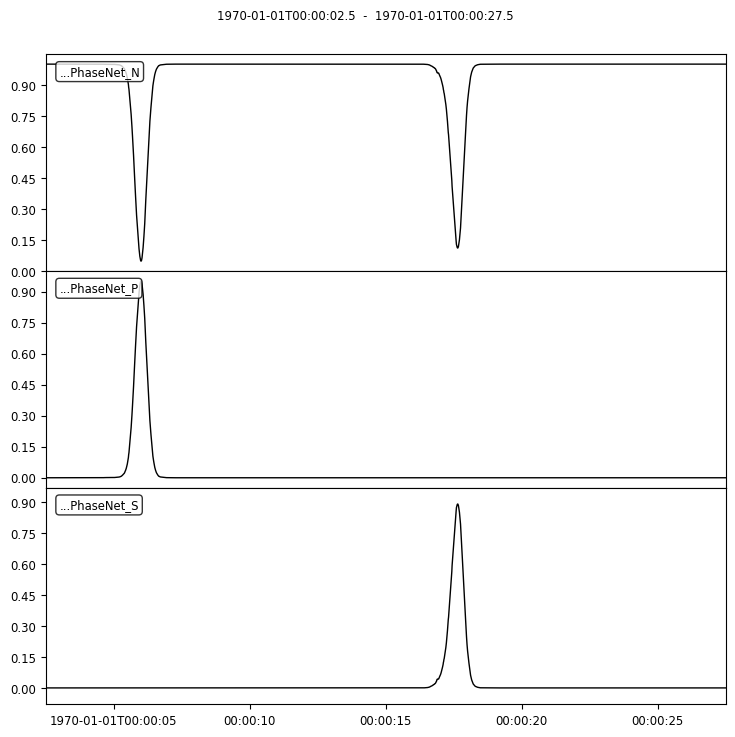

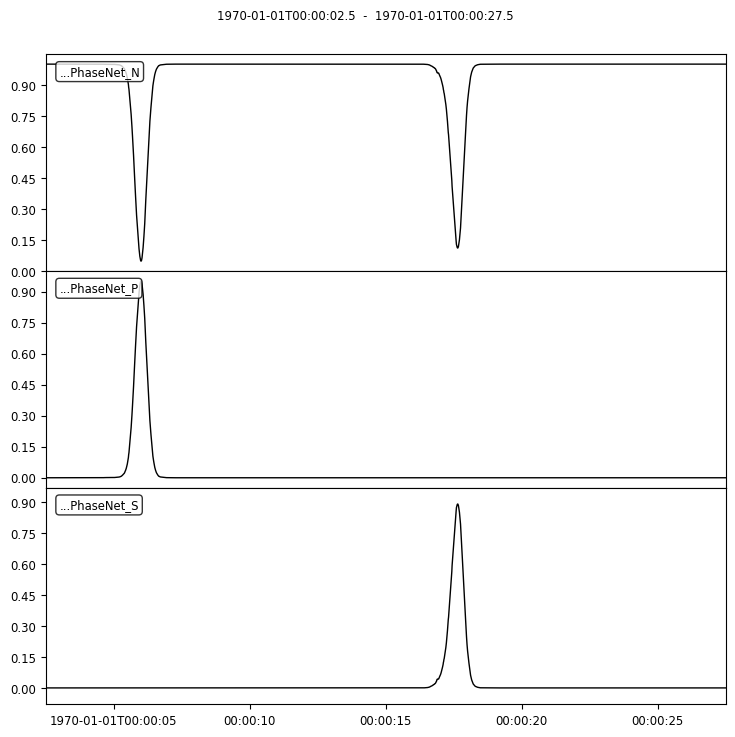

In [17]:
pn_preds.plot()
